In [80]:
import networkx as nx
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt

In [1]:
!wget https://snap.stanford.edu/data/twitch.zip

--2021-11-09 18:47:37--  https://snap.stanford.edu/data/twitch.zip
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2842994 (2,7M) [application/zip]
Saving to: ‘twitch.zip’

twitch.zip          100%[===================>]   2,71M   887KB/s    in 3,1s    

2021-11-09 18:47:41 (887 KB/s) - ‘twitch.zip’ saved [2842994/2842994]



In [2]:
!unzip twitch.zip

Archive:  twitch.zip
   creating: twitch/
   creating: twitch/DE/
  inflating: twitch/DE/musae_DE.json  
  inflating: twitch/DE/musae_DE_edges.csv  
  inflating: twitch/DE/musae_DE_target.csv  
   creating: twitch/ENGB/
  inflating: twitch/ENGB/musae_ENGB_edges.csv  
  inflating: twitch/ENGB/musae_ENGB_features.json  
  inflating: twitch/ENGB/musae_ENGB_target.csv  
   creating: twitch/ES/
  inflating: twitch/ES/musae_ES_edges.csv  
  inflating: twitch/ES/musae_ES_features.json  
  inflating: twitch/ES/musae_ES_target.csv  
   creating: twitch/FR/
  inflating: twitch/FR/musae_FR_edges.csv  
  inflating: twitch/FR/musae_FR_features.json  
  inflating: twitch/FR/musae_FR_target.csv  
   creating: twitch/PTBR/
  inflating: twitch/PTBR/musae_PTBR_edges.csv  
  inflating: twitch/PTBR/musae_PTBR_features.json  
  inflating: twitch/PTBR/musae_PTBR_target.csv  
   creating: twitch/RU/
  inflating: twitch/RU/musae_RU_edges.csv  
  inflating: twitch/RU/musae_RU_features.json  
  inflating: twitc

In [167]:
COUNTRY = "RU"

In [168]:
GRAPH_DIR = f"twitch/{COUNTRY}"

In [169]:
edges = pd.read_csv(GRAPH_DIR + f"/musae_{COUNTRY}_edges.csv")

In [170]:
edges_renamed = edges.rename(columns={"from":"Source","to":"Target"})

In [171]:
edges_renamed

,Source,Target
0,0,646
1,0,2510
2,0,2425
3,0,2596
4,0,85
...,...,...
37299,4313,4338
37300,4313,1199
37301,4328,4337
37302,4333,4351


In [172]:
edges_renamed.to_csv(GRAPH_DIR + f"/musae_{COUNTRY}_edges_gephi.csv",index=None)

In [173]:
nodes = pd.read_csv(GRAPH_DIR + f"/musae_{COUNTRY}_target.csv")

In [174]:
nodes

,id,days,mature,views,partner,new_id
0,43622128,1910,False,2002,False,1076
1,32314097,2273,True,1885,False,1090
2,112985248,998,False,14538,False,633
3,54595718,1738,True,8541,False,2238
4,72920173,1461,False,49854,False,1662
...,...,...,...,...,...,...
4380,89307159,1267,False,31085,False,3249
4381,91304162,1244,False,37971,False,2287
4382,142285340,663,False,24686,False,1095
4383,46489985,1885,False,12129,False,207


In [175]:
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(edges, source='from', target='to', create_using=Graphtype)

In [176]:
# Na podstawie Epidemic Modeling with Modified Small-World Networks, Jingxin Zhang

In [177]:
def save_data_to_file(status,steps,path):
    df_status = pd.DataFrame(status,columns=["status"]).reset_index().rename(columns={"index":"node"})
    df_status.to_csv(f"{path}/nodes_{steps}.csv",index=None)

In [178]:
def get_path(name,directory):
    dirpath = Path(directory) / name
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    
    path = f"./{directory}/{name}"
    os.mkdir(path)
    return path

In [179]:
# get_path("","simulation_results")

In [180]:
def simulate_SIR(graph,k,p,T,name,directory="./simulation_results/"):
    n = graph.number_of_nodes()
    path = get_path(name,directory)
    
    steps = 1
    status = [0]*n # status=O - suspectible
    days = [0]*n
    infected = []
    cum_infected_data = [0]
    infected_data = [0]
    
    infected = random.sample(list(graph.nodes()),k)
    infected_data.append(k)
    
    for v in infected:
        status[v] = 1 # status=1 - infected
        days[v] = T
        cum_infected_data[-1] = cum_infected_data[-1] + 1/n
        
    save_data_to_file(status,steps,path)
        
    while len(infected) > 0:
        steps += 1
        cum_infected_data.append(cum_infected_data[-1])
        new_infected = []
        
        for node in infected:
            for v in list(graph.neighbors(node)):
                if status[v] == 0 and random.random() < p:
                    new_infected.append(v)
                    status[v] = 1
                    days[v] = T
                    cum_infected_data[-1] = cum_infected_data[-1] + 1/n
            days[node] = days[node] - 1
            if days[node] < 1:
                infected.remove(node)
                status[node] = 2 # status=2 - recovered
                
        infected = infected + new_infected
        infected_data.append(len(infected))
        
        if steps % 5 == 0:
            save_data_to_file(status,steps,path)
            
    save_data_to_file(status,steps,path)
    
    return cum_infected_data, infected_data, steps

In [181]:
def simulate_SEIR(graph,k,p1,p2,T1,T2,name,directory="./simulation_results",snapshot_frequency=10): 
    # p1 - exposed period transmisson rate, 
    # p2 - infection period transmission rate, 
    # T1 - exposed period, 
    # T2 - infection period
    
    path = get_path(name,directory)
    
    n = graph.number_of_nodes()
    
    steps = 1
    status = [0]*n
    days = [0]*n
    infected = []
    exposed = []
    cum_infected_data = [0]
    cum_exposed_data = [0]
    infected_data = [0]
    exposed_data = [k]
    
    exposed = random.sample(list(graph.nodes()), k)
    # exposed_data.append(k)
    # infected_data.append(0)
    
    for v in exposed:
        status[v] = 1 # status=1 - exposed
        days[v] = T1
        cum_exposed_data[-1] = cum_exposed_data[-1] + 1/n
        
    save_data_to_file(status,steps,path)
        
    while len(exposed) > 0 or len(infected) > 0:
        steps += 1

        cum_exposed_data.append(cum_exposed_data[-1])
        cum_infected_data.append(cum_infected_data[-1])
        new_infected = []
        new_exposed = []
        
        for node in exposed:
            
            for v in list(graph.neighbors(node)):
                if status[v] == 0 and random.random() < p1:
                    new_exposed.append(v)
                    status[v] = 1
                    days[v] = T1
                    cum_exposed_data[-1] = cum_exposed_data[-1] + 1/n
            days[node] = days[node] - 1
                
            if days[node] < 1:
                exposed.remove(node)
                new_infected.append(node)
                cum_infected_data[-1] = cum_infected_data[-1] + 1/n
                status[node] = 2 # status=2 - infected
                days[node] = T2

        for node in infected:
            
            for v in list(graph.neighbors(node)):
                if status[v] == 0 and random.random() < p2:
                    new_exposed.append(v)
                    status[v] = 1
                    days[v] = T1
                    cum_exposed_data[-1] = cum_exposed_data[-1] + 1/n
            
            days[node] = days[node] - 1
                
            if days[node] < 1:
                infected.remove(node)
                status[node] = 3 # status=3 - recovered/resistant

        exposed = exposed + new_exposed
        infected = infected + new_infected
            
        exposed_data.append(len(exposed))    
        infected_data.append(len(infected))
        
        if steps % snapshot_frequency == 0:
            save_data_to_file(status,steps,path)
            
    save_data_to_file(status,steps,path)
    
    return cum_exposed_data, cum_infected_data, exposed_data, infected_data, steps

In [182]:
start_time = time.time()
cum_infected, infected, steps = simulate_SIR(G,3,0.01,14,f"twitch_{COUNTRY}_sir")
end_time = time.time()

In [183]:
end_time - start_time

1.1114914417266846

In [184]:
steps

96

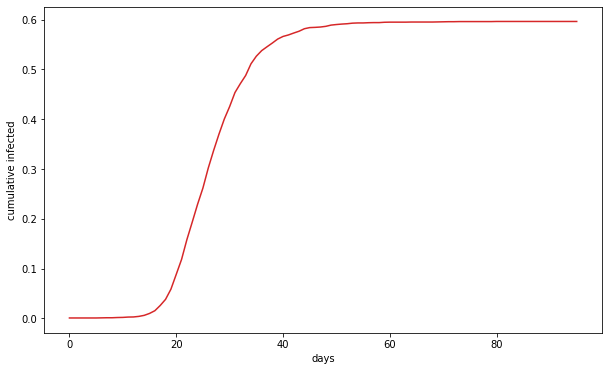

In [185]:
plt.figure(figsize=(10,6))
plt.plot(cum_infected,c="tab:red")
plt.xlabel("days")
plt.ylabel("cumulative infected")
plt.show()

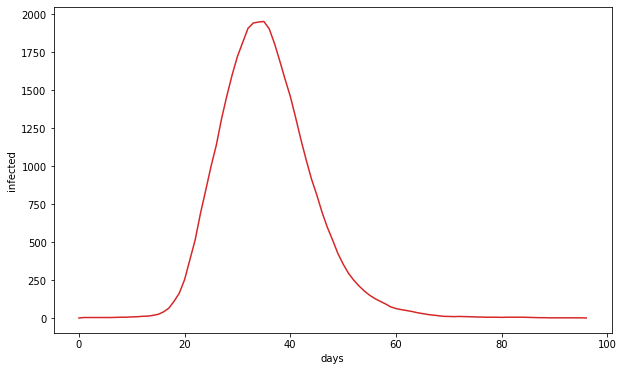

In [186]:
plt.figure(figsize=(10,6))
plt.plot(infected,c="tab:red")
plt.xlabel("days")
plt.ylabel("infected")
plt.show()

In [187]:
start_time = time.time()
cum_exposed, cum_infected, exposed, infected, steps = simulate_SEIR(G,3,0.05,0.1,7,7,f"twitch_{COUNTRY}_seir")
end_time = time.time()

In [188]:
end_time - start_time

1.2080698013305664

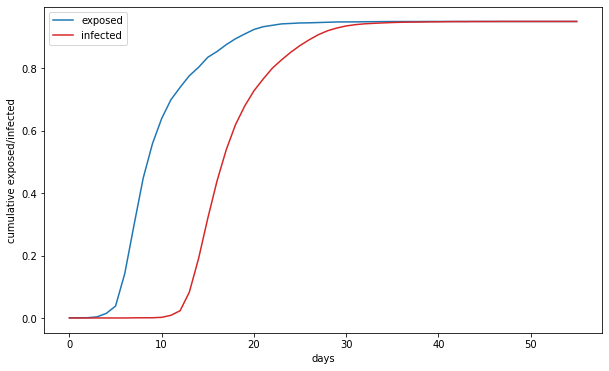

In [189]:
plt.figure(figsize=(10,6))
plt.plot(cum_exposed,c="tab:blue",label="exposed")
plt.plot(cum_infected,c="tab:red",label="infected")
plt.xlabel("days")
plt.ylabel("cumulative exposed/infected")
plt.legend()
plt.show()

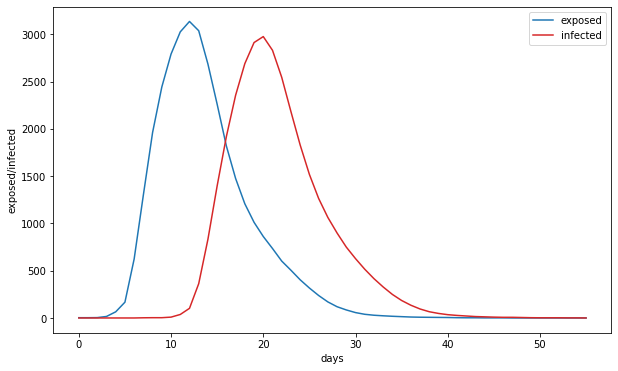

In [190]:
plt.figure(figsize=(10,6))
plt.plot(exposed,c="tab:blue",label="exposed")
plt.plot(infected,c="tab:red",label="infected")
plt.xlabel("days")
plt.ylabel("exposed/infected")
plt.legend()
plt.show()